In [652]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
import re
import contextily as ctx
import descartes as dsc
import geopandas as gp
from shapely.ops import cascaded_union
from datetime import datetime
import pgeocode
import os
from matplotlib import colors as cls
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc
import matplotlib.dates as mdates
import imageio
import math

# Preparing the 'working' dataframe and save it as  'pkl' file

In [2]:
with open('df_raw.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [5]:
post= df_2020['RegAddress.PostCode']

In [ ]:
#retrieve information from the postcode as it is intuetively the most precise option
nomi = pgeocode.Nominatim('GB')
Long=[]
Lat=[]
for p in post:
    if type(p)==str:
        a=nomi.query_postal_code(p)
        Long.append(a['longitude'])
        Lat.append(a['latitude'])
    else:
        Long.append(np.nan)
        Lat.append(np.nan)

In [85]:
df_raw['Long']=Long
df_raw['Lat']=Lat
df_raw.dropna(subset=['Long'],inplace=True)

In [89]:
df_raw.to_pickle('df_raw_post.pkl')

# Open the 'pkl' file containing latitude and longitude and start building the geospatial chart

In [7]:
with open('df_raw_post.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [62]:
#Considering companies incorporated after 2020
df_2020=df_raw.loc[df_raw['IncorporationDate']>pd.Timestamp(2020, 1, 1)]

In [63]:
#loading shp file with London Wards (this is a very granular data)
fp = "/Users/nikigelkott/2. Digital value/london/London-wards-2018_ESRI/London_Ward.shp"
data = gp.read_file(fp)
data=data.to_crs(epsg=3857)

In [64]:
#Initialize geopandas DataFrame with companies incorporated after 2020
df_points=df_2020.loc[:,('Long', 'Lat','IncorporationDate','SICCode.SicText_1')]
points = gp.points_from_xy(df_2020.Long,df_2020.Lat)
companies_UK = gp.GeoDataFrame(df_points, geometry=points)
companies_UK.set_crs("EPSG:4326", inplace=True)
companies_UK=companies_UK.to_crs(epsg=3857)

In [65]:
#check whether all point lie within bondaries of the London
boundary = gp.GeoSeries(cascaded_union(data.geometry))
companies_London=companies_UK.loc[companies_UK.geometry.within(boundary[0])]

/var/folders/lp/kfk0rkcj6bj31b_4y46369qr0000gn/T/ipykernel_62255/2126543259.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary = gp.GeoSeries(cascaded_union(data.geometry))


In [116]:
#Count the number of companies per each Ward (polygon)
def count_points(geo_data,df):
    polygons = geo_data.geometry
    points=df.geometry
    pts = points.copy() 
    # We're going to keep a list of how many points we find.
    pts_in_polys = []
    # Loop over polygons with index i.
    for poly in polygons:
        # Keep a list of points in this poly
        pts_in_this_poly = []
        # Now loop over all points
        for pt in pts:
            if poly.contains(pt):
                pts_in_this_poly.append(pt)
        pts_in_polys.append(len(pts_in_this_poly))
    geo_data['count']=pts_in_polys
    return geo_data

In [66]:
#Retrieve the corresponding month for UK and London
companies_London['month_year'] = pd.to_datetime(companies_London['IncorporationDate']).dt.to_period('M')
companies_UK['month_year'] = pd.to_datetime(companies_UK['IncorporationDate']).dt.to_period('M')

/Users/nikigelkott/opt/anaconda3/envs/value/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [67]:
#Preparing for iterating over months
periods=sorted(companies.month_year.unique())

In [157]:
#merged_df['count']=np.log(merged_df['count'])

/Users/nikigelkott/opt/anaconda3/envs/value/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
output_path = '/Users/nikigelkott/Desktop/geocharts'
filenames = []
# counter for the for loop
i = 0
# start the for loop to create one map per month
for period in periods:
    #LONDON data
    companies_per_month_London=companies_London.loc[companies_London.month_year==period]
    merged_df=count_points(data,companies_per_month_London)
    #UK data
    companies_per_month=companies_UK.loc[companies_UK.month_year==period]

    fig, ax = plt.subplots(1, 1,figsize=(20,20))
    divider = make_axes_locatable(ax)
    #LONDON plot
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ax=merged_df.plot(column='count',legend=True,
                      edgecolor='k',
                      norm=colors.LogNorm(vmin=1, vmax=merged_df['count'].max()),ax=ax,
                     cax=cax)
    ax.set_title('Number of companies incorporated in London: '+str(np.sum(merged_df['count'])), \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    ax.annotate(str(period),
            xy=(0.1, 0.19), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    #UK plot
    axins = inset_axes(ax, width=3, height=5.5,
                       loc=4)
    companies_per_month.plot(markersize=0.05,alpha=0.5,ax=axins,color='firebrick')
    axins.set_title('In UK: '+str(len(companies_per_month)), \
              fontdict={'fontsize': '20',
                         'fontweight' : '3'})
    UK.plot(color='white',edgecolor='black',ax=axins)
    #prettify the background
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
    ctx.add_basemap(axins,source=ctx.providers.CartoDB.Positron)
    axins.set_axis_off()
    ax.set_axis_off()
    #plt.tight_layout()
    #preparing fot GIF creation
    filename = f'{i}.png'
    i+=1
    filenames.append(filename)
    plt.savefig(filename,bbox_inches='tight')
    plt.close()

with imageio.get_writer('mygif.gif', mode='I',duration=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
# Remove files
for filename in set(filenames):
    os.remove(filename)

# Produce interactive bokeh visualization

In [447]:
#Let's compare 2019 and 2020
df_modern=df_raw.loc[(df_raw['IncorporationDate']>=pd.Timestamp(2019, 1, 1))&
                    (df_raw['IncorporationDate']<pd.Timestamp(2021, 1, 1))]

In [448]:
#Drop 'None Supplied' SIC code
df_modern.drop(
    df_modern.index[df_modern['SICCode.SicText_1'] == 'None Supplied'], inplace=True) 

/Users/nikigelkott/opt/anaconda3/envs/value/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [449]:
#Retreive the code
sic_str=df_modern['SICCode.SicText_1'].str.split()
df_modern['SICCode1']=sic_str.apply(lambda x: x[0])

/var/folders/lp/kfk0rkcj6bj31b_4y46369qr0000gn/T/ipykernel_62255/2641661213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modern['SICCode1']=sic_str.apply(lambda x: x[0])


In [455]:
#Counts per Year
counts_per_year=df_modern.groupby([df_modern.IncorporationDate.dt.to_period("Y"), 'SICCode.SicText_1']).size()
counts_per_year=pd.DataFrame(counts_per_year)
counts_per_year=counts_per_year.reset_index()
counts_per_year.columns=['IncorporationDate', 'SICCode.SicText_1', 'count']

In [459]:
#pick only those SIC counts greater then o
counts_per_year=counts_per_year.loc[counts_per_year['count']>0]
#convert datetime period into str
counts_per_year['Year']=counts_per_year.IncorporationDate.apply(lambda x: str(x))
#Year to integer
counts_per_year['Year']=counts_per_year.Year.apply(lambda x: int(x))
#create a pivot table to obtain counts for each SIC code per Year
df=pd.pivot_table(counts_per_year, values='count', 
                     index=['Year'], 
                     columns='SICCode.SicText_1')
df=df.reset_index()

In [604]:
####Retrieve values for bokeh ColumnDataSource

#counts for 2019 and 2020 for each SIC code
y_points=[]
year20=[]
year21=[]
#simply [2019,2019.5,2020] for each line
x_points=[]
#add point in the middle of the line to let bokeh hover display hover information in the middle 
c_points=[]
codes=[]
#change (count 2020 / count 2019)
change_list=[]
#colors for each line
colors=[]
width=[]
for code in df.columns[1:]:
    x=list(df[code])
    if not math.isnan(x[0]) and not math.isnan(x[1]):
        y_point=[x[0],np.mean(x),x[1]]
        y_points.append(y_point)
        x_points.append([2019,2019.5,2020])
        codes.append(code)
        year20.append(x[0])
        year21.append(x[1])
        perc_change=(x[1]/x[0])-1
        width.append(np.mean(x))
        change_list.append(perc_change)
        #BOKEH is 'unfriendly' (i would even say horrible) in assigning color pallets to multiple lines 
        #so let's assign them manually
        if perc_change<=-0.5:
            colors.append('red')
        elif -0.5<perc_change<0:
            colors.append('tomato')
        elif perc_change>2:
            colors.append('lime')
        else:
            colors.append('green')

In [605]:
#scale the width of the line from 0.2 to 6
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler((0.2,6))
width=np.array(width)
width=width.reshape(-1, 1)
width = min_max_scaler.fit_transform(width)
#adjust the alpha depending on the average count per SIC code
alpha=1/width
alpha=[float(i) if i<3 else 1 for i in alpha]

In [610]:
from bokeh.plotting import figure, output_file, save
from bokeh.plotting import show, figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models import BoxZoomTool
from bokeh.models import Range1d
TOOLTIPS = [("SIC Code", "@Codes"),
           ("2020", "@Year20"),
            ("2021", "@Year21")
           ,("Change", "@Change")
           ]
source = ColumnDataSource(data=dict(
    ys=y_points,
    xs=x_points,
    Codes=codes,
    Change=change_list,
    color=colors,
    Year20=year20,
    Year21=year21,
    Sizes=width,
    Alpha=alpha,
))
p = figure(width=600, height=650,
           title="Incorporated UK companies aggregated by SIC code", 
           y_axis_label="Number of companies opened per year",
           tools="hover,reset,ypan,ywheel_zoom",
           tooltips=TOOLTIPS,
           #setting limits for zooming and scrolling
           y_range=Range1d(0, 30000, bounds="auto"),
          )
p.line([2019,2019],[0,30000], line_width=2,color='black')
p.line([2020,2020],[0,30000], line_width=2,color='black')
p.multi_line(xs='xs', ys='ys', source=source,line_color='color',line_width='Sizes',alpha='Alpha')
p.xaxis.ticker = [2019, 2020]
p.xaxis.major_label_text_font_size = "20pt"
output_file(filename="Chart3.html", title="Chart by Evgeny")
show(p)

# APPENDIX (Fail to show companies incorporated in St. James)

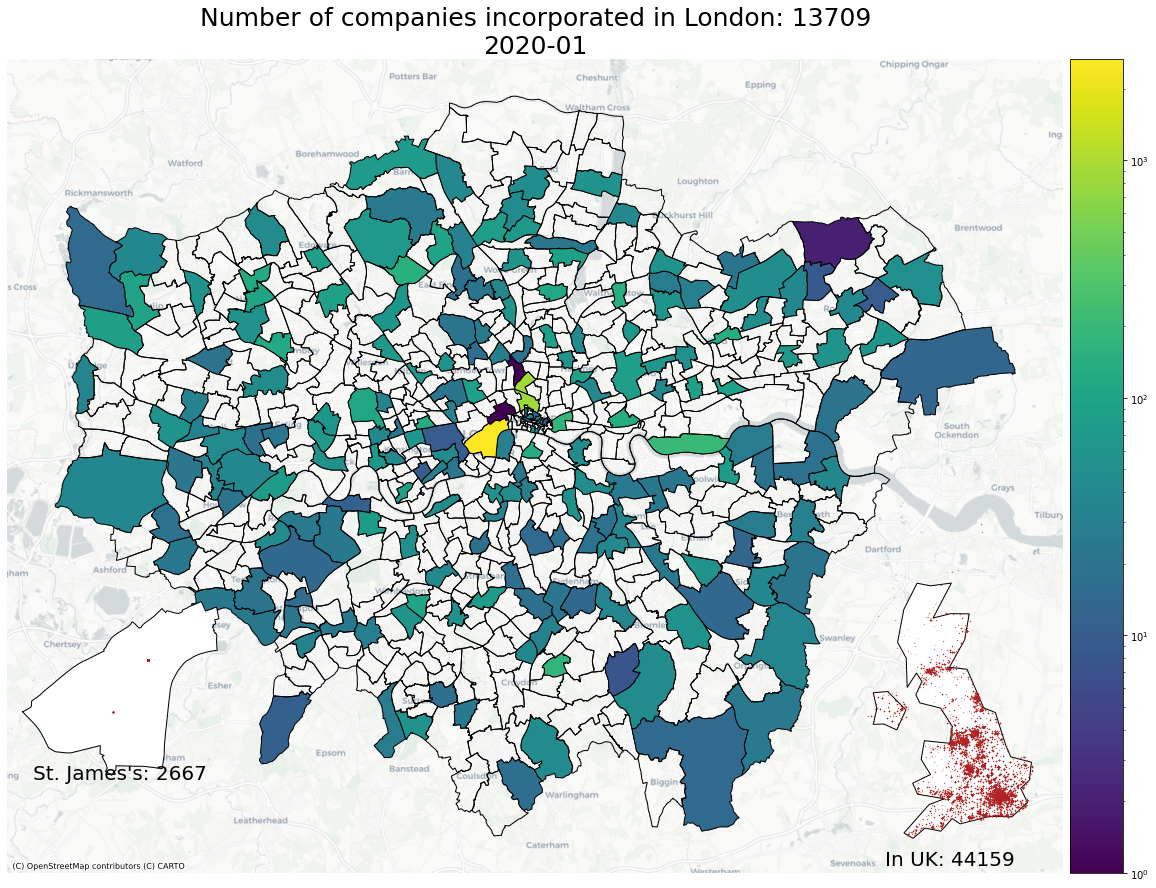

In [762]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
UK=world.loc[world.name=='United Kingdom']
UK=UK.to_crs(epsg=3857)
cental_boundary=merged_df.iloc[481,6]

output_path = '/Users/nikigelkott/Desktop/geocharts'
filenames = []
# counter for the for loop
i = 0
# start the for loop to create one map per month
#for period in periods:
#LONDON data
companies_per_month_London=companies_per_month_London.sample(frac=0.05, random_state=1)

companies_per_month_London=companies_London.loc[companies_London.month_year==periods[0]]
merged_df=count_points(data,companies_per_month_London)
#UK data
companies_per_month=companies_per_month.sample(frac=0.05, random_state=1)
companies_per_month=companies_UK.loc[companies_UK.month_year==periods[0]]

fig, ax = plt.subplots(1, 1,figsize=(20,20))
divider = make_axes_locatable(ax)
#LONDON plot
cax = divider.append_axes("right", size="5%", pad=0.1)
ax=merged_df.plot(column='count',legend=True,
                  edgecolor='k',
                  norm=cls.LogNorm(vmin=1, vmax=merged_df['count'].max()),ax=ax,
                 cax=cax)
ax.set_title('Number of companies incorporated in London: '+str(np.sum(merged_df['count']))
             +'\n'+str(period), \
            fontdict={'fontsize': '25',
                        'fontweight' : '3'})
#UK plot
axins = inset_axes(ax, width=3, height=5,
                   loc=4)
UK.plot(color='white',edgecolor='black',ax=axins)
companies_per_month.plot(markersize=0.05,alpha=0.5,ax=axins,color='firebrick')
axins.set_title('In UK: '+str(len(companies_per_month)), \
          fontdict={'fontsize': '20',
                     'fontweight' : '3'},y=-0.01)
#St. James district
axins1 = inset_axes(ax, width=3, height=5,
                   loc=3)


james_points_df=companies_per_month_London.loc[companies_per_month_London.geometry.within(cental_boundary)]
St_James=merged_df.loc[merged_df['count']==2667]

St_James.plot(color='white',edgecolor='black',ax=axins1)
james_points_df.plot(markersize=1,alpha=0.5,ax=axins1,color='firebrick')
axins1.set_title("St. James's: " +str(len(james_points_df)), \
          fontdict={'fontsize': '20',
                     'fontweight' : '3'},y=-0.01)


#prettify the background
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

axins1.set_axis_off()
axins.set_axis_off()
ax.set_axis_off()
#plt.tight_layout()
#preparing fot GIF creation
#filename = f'{i}.png'
i+=1
#filenames.append(filename)
#plt.savefig(filename,bbox_inches='tight')
plt.show()

